### Quickstart Tutorial: Using the `ohana` Predictor

This notebook demonstrates the standard, high-level way to run anomaly detection using the `ohana` package. This is the recommended workflow for most use cases.

We will use the main `Predictor` class, which handles all the complex steps internally. The process is simple:
1.  Configure paths and settings.
2.  Initialize the `Predictor`.
3.  Run the `predict` method.
4.  Visualize the results.

##### Step 1: Imports and Configuration

First, we'll import the necessary classes and define the paths for our model, data, and output files.

In [1]:
import torch
import os
import json
import numpy as np
import sys

In [2]:
print(f"Setting PyTorch to use {os.cpu_count() or 8} threads.")
torch.set_num_threads(os.cpu_count() or 8)
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count() or 8)
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count() or 8)

Setting PyTorch to use 16 threads.


In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

src_path = os.path.join(project_root, 'src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [4]:
# Import the necessary classes from your ohana package
# !NOTE: Make sure the 'ohana' directory is in your Python path

from ohana import UNet3D
from ohana import Predictor
from ohana import DataLoader
from ohana import Preprocessor
from ohana import ResultVisualizer
from ohana import DetectorConfig

In [5]:
""" Configuration """
# !NOTE: Replace these with the actual paths to your files.

# Path to the trained model
MODEL_PATH = "../trained_models/old_best_model_unet3d.pth"

# Path to the config file that was used for model training
CONFIG_PATH = "../configs/creator_config.yaml"

# Path to the exposure you want to run the predictions on
EXPOSURE_PATH = "/Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits"

# Path to where the processed exposure is saved to (MUST BE .NPY)
PROCESSED_EXPOSURE_FILE = 'processed/ap30_100k_0p8m0p3_fullnoi_E001_18220_processed.npy'

# Directory where model predictions will be stored
OUTPUT_DIR = "tut_prediction_outputs"

# Where processed exposure will be saved
PROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, PROCESSED_EXPOSURE_FILE)

# Where prediction mask with be saved
MASK_PATH = os.path.join(OUTPUT_DIR, 'prediction_mask.npy')

# Where detections will be saved
DETECTIONS_PATH = os.path.join(OUTPUT_DIR, 'detections.json')

In [6]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


##### Step 2: Run the Prediction

This is the core of the workflow. We create an instance of the `Predictor` class and call the `.predict()` method. The class will handle loading the model, preprocessing the data (and caching it), running inference, and finding objects.

In [7]:
config = DetectorConfig()

In [8]:
"""Initialize the predictor"""
# This loads the model and sets up the configuration.
print("Initializing the predictor...")
predictor = Predictor(model_path = MODEL_PATH, config=config)

2025-08-07 10:54:14,005 - INFO - Model path provided: ../trained_models/old_best_model_unet3d.pth. Rule-based detectors will be used.


Initializing the predictor...
ReferencePixelCorrector initialized with x_opt=64, y_opt=4.


In [ ]:
print(f"Running prediction on {EXPOSURE_PATH}...")
anomalies = predictor.predict(
    exposure_path=EXPOSURE_PATH,
    output_dir=OUTPUT_DIR # Change this to your desired output location
)

print(f"Found {len(anomalies)} total anomalies.")
print(anomalies)

2025-08-07 10:54:14,012 - INFO - --- Analyzing exposure: /Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits ---
2025-08-07 10:54:14,014 - INFO - Loading cached raw data from tut_prediction_outputs/raw/ap30_100k_0p8m0p3_fullnoi_E001_18220_raw.npy...


Running prediction on /Volumes/jwst/ilongo/raw_data/18220_Euclid_SCA/ap30_100k_0p8m0p3_fullnoi_E001_18220.fits...


2025-08-07 10:54:17,336 - INFO - Loading cached processed data from tut_prediction_outputs/processed/ap30_100k_0p8m0p3_fullnoi_E001_18220_processed.npy...


In [ ]:
def to_builtin(o):
    if isinstance(o, np.generic):     # catches int64, float64, bool_ …
        return o.item()               # converts to regular int/float/bool
    raise TypeError(f"{type(o)} is not JSON serializable")

with open(DETECTIONS_PATH, "w") as f:
    json.dump(anomalies, f, indent=4, default=to_builtin)

##### Step 3: Visualize the Results

Now that the prediction is done and all output files are saved, we can use the `ResultVisualizer` to see the outcome.

In [ ]:
print("Generating visualization...")

# Initialize the visualizer with the paths to our saved results
visualizer = ResultVisualizer(
    processed_data_path=PROCESSED_DATA_PATH
)

# Load the list of detected anomalies
visualizer.load_detection_list(results_path=DETECTIONS_PATH)

2025-08-07 10:52:17,367 - INFO - Loading processed data from: tut_prediction_outputs/processed/ap30_100k_0p8m0p3_fullnoi_E001_18220_processed.npy


Generating visualization...


2025-08-07 10:52:20,830 - INFO - Loaded 174 detections from tut_prediction_outputs/detections.json


This will generate the main overview plot, showing the locations of all detected anomalies overlaid on the median image of the exposure.

2025-08-07 10:52:20,843 - INFO - Creating prediction mask from detection list...
2025-08-07 10:52:20,912 - INFO - Mask created with 0 classes.


ValueError: 'Blues_R' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

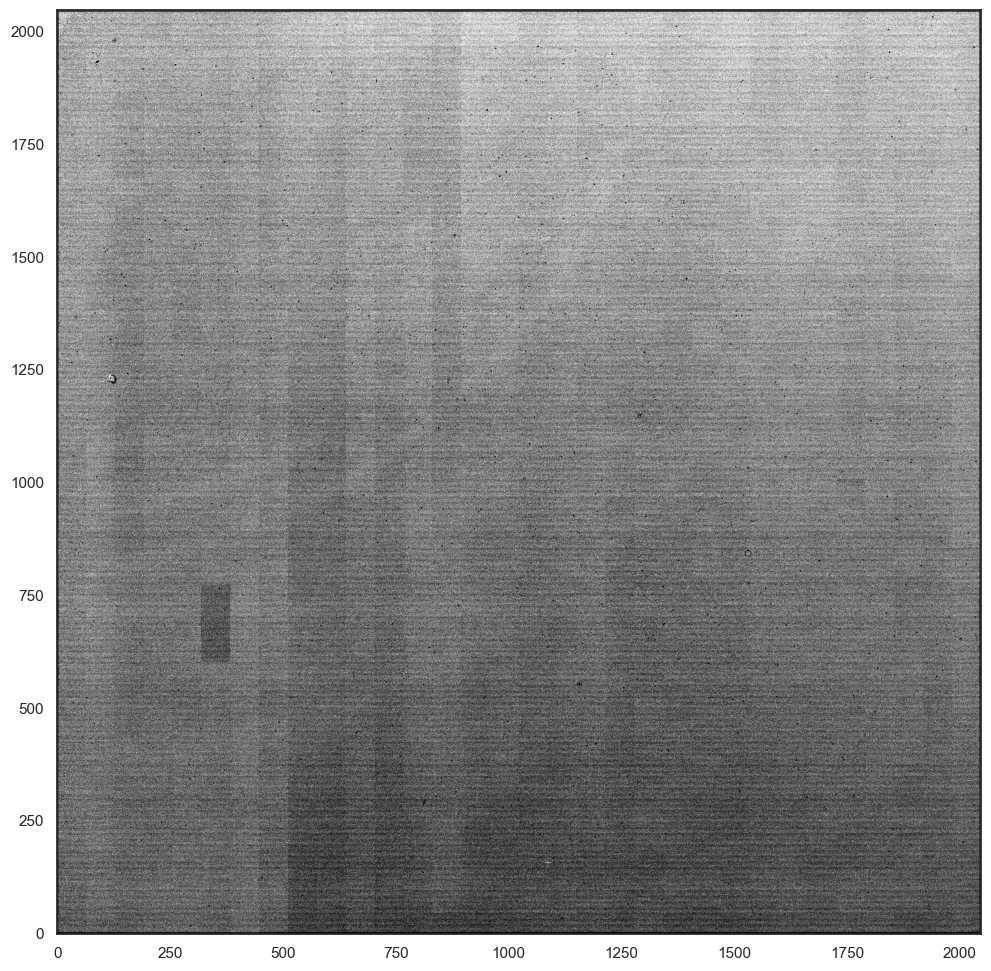

In [ ]:
# Generate and display the plot
visualizer.plot_full_mask_overlay()

Here, we can inspect the individual events. The `max_plots` argument is useful to avoid generating too many plots at once if you have a large number of detections.

2025-08-07 10:18:31,582 - INFO - Limiting plots to the first 5 detections.
2025-08-07 10:18:31,583 - INFO - Generating detailed plots for 5 detections...
2025-08-07 10:18:31,583 - INFO - Plotting detection 1/5: Type = cosmic_ray_candidate


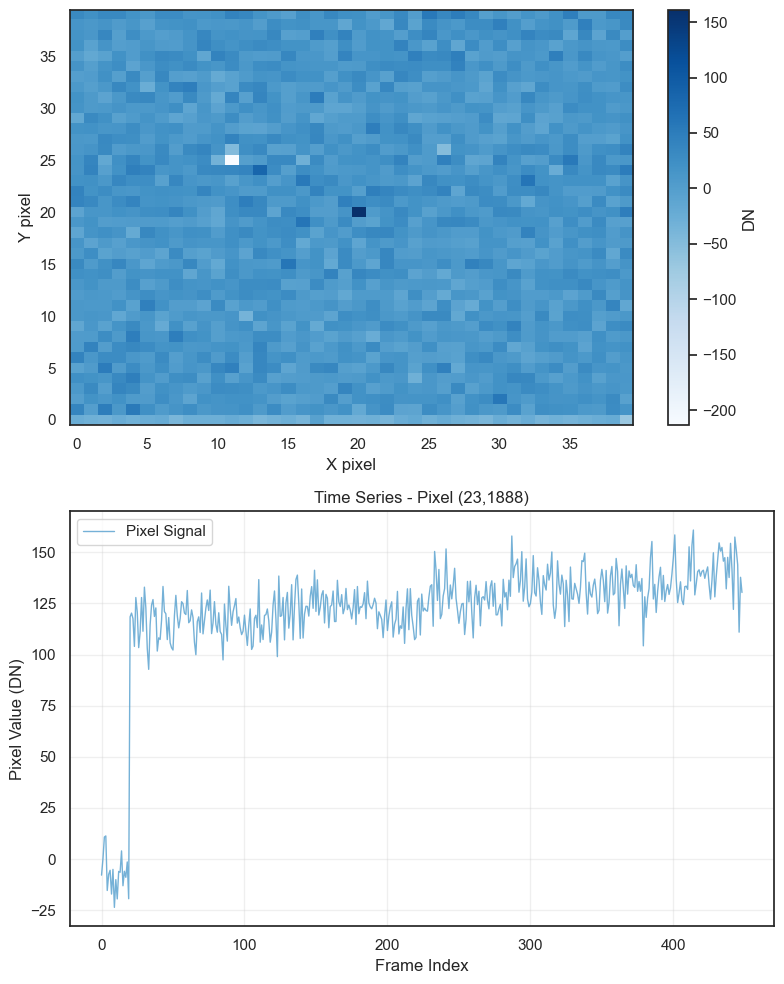

2025-08-07 10:18:31,979 - INFO - Plotting detection 2/5: Type = cosmic_ray_candidate


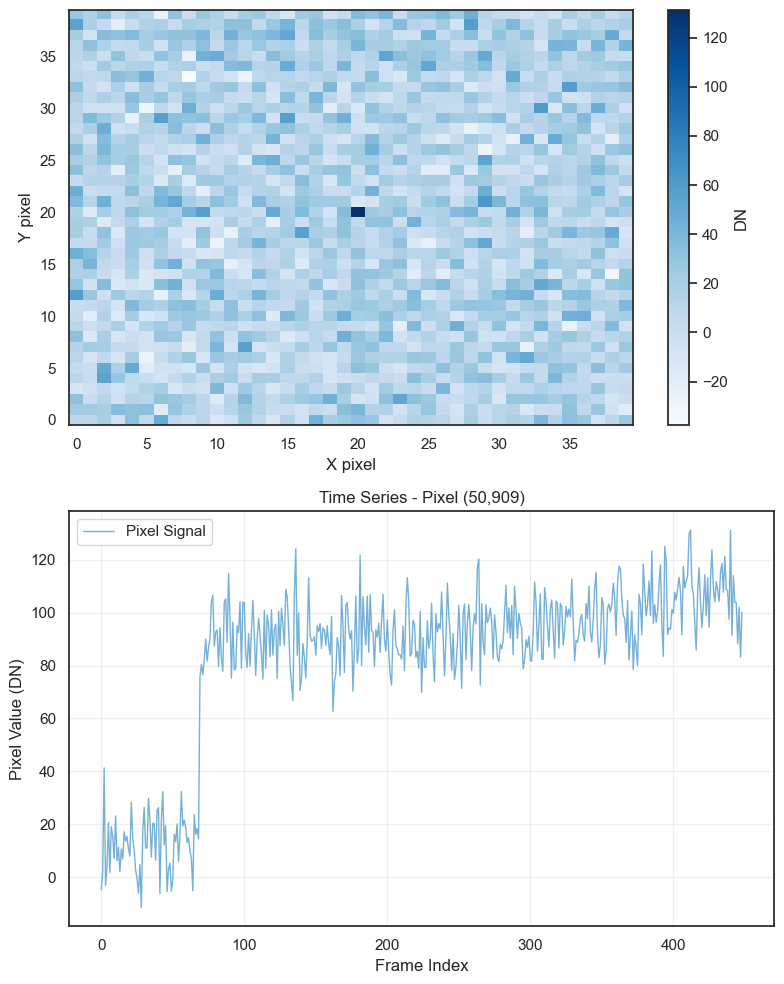

2025-08-07 10:18:32,469 - INFO - Plotting detection 3/5: Type = cosmic_ray_candidate


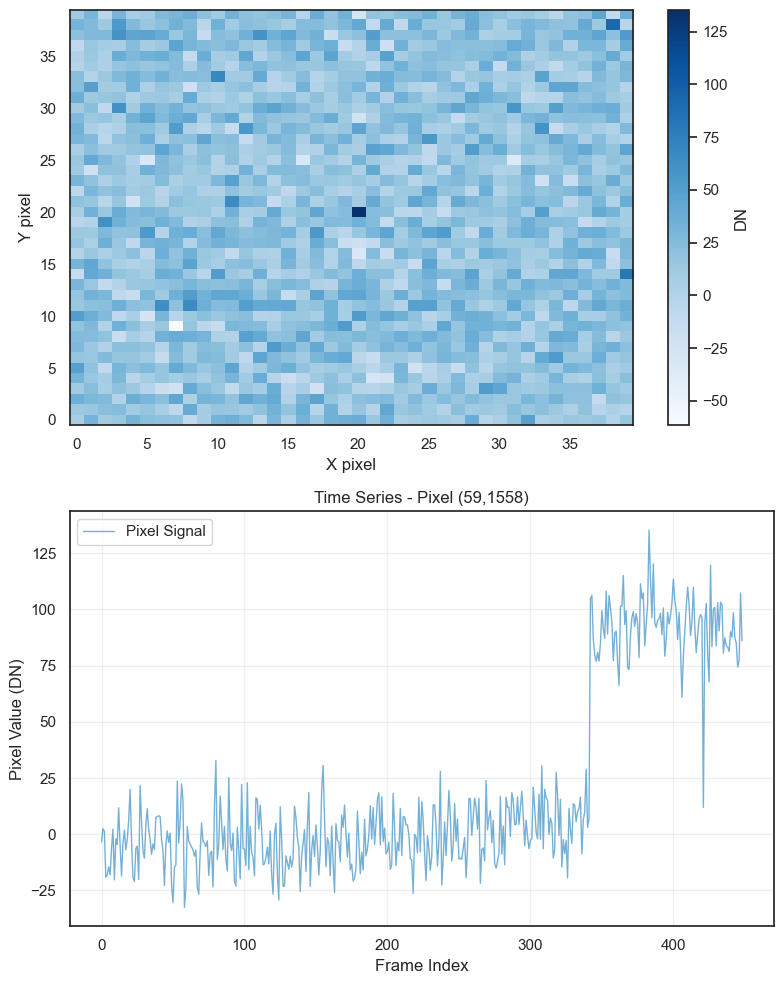

2025-08-07 10:18:32,824 - INFO - Plotting detection 4/5: Type = cosmic_ray_candidate


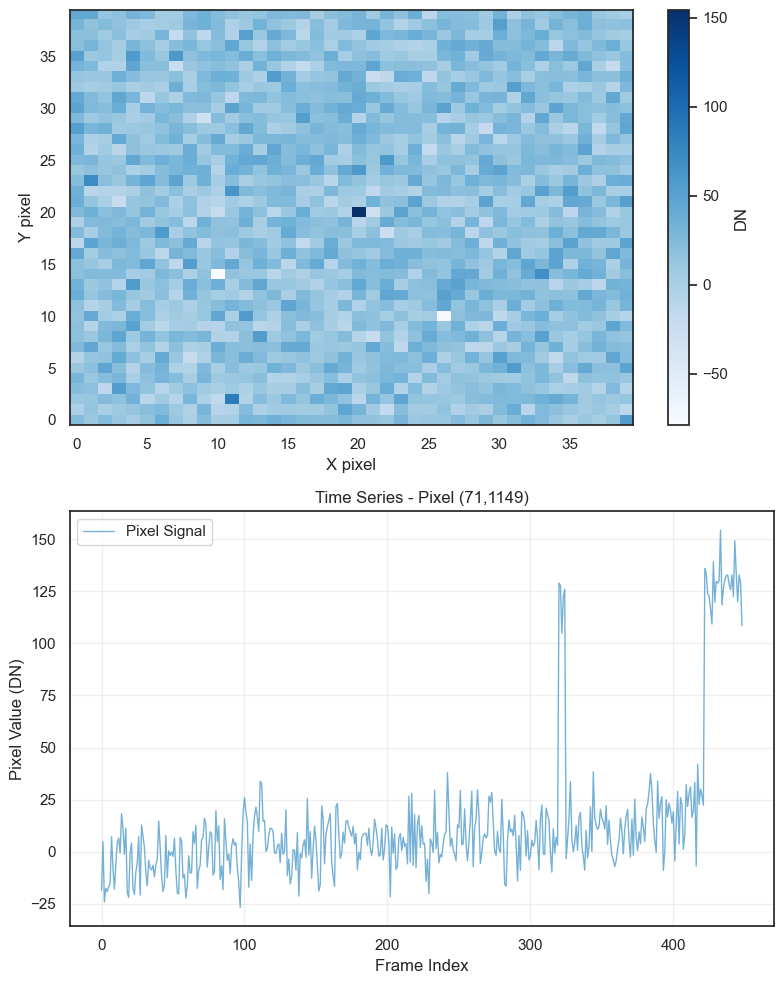

2025-08-07 10:18:33,179 - INFO - Plotting detection 5/5: Type = cosmic_ray_candidate


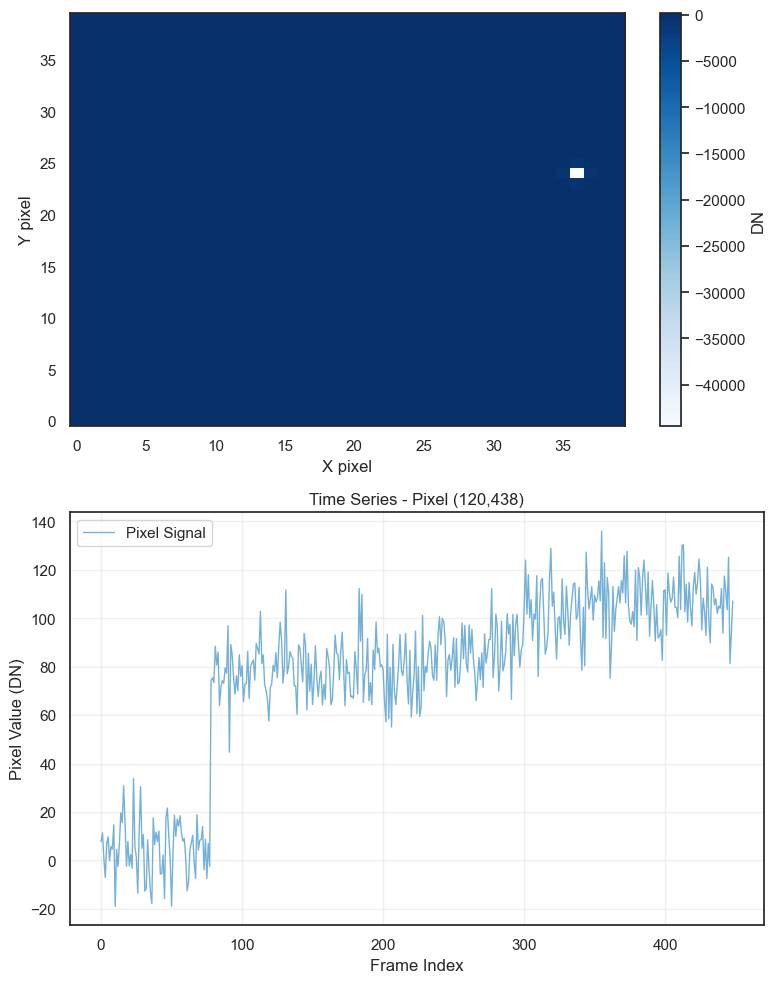

In [ ]:
visualizer.plot_all_detections(max_plots=5)

Finally, we can create a movie for a specific event to see its evolution over time. This code finds the first detected cosmic ray and generates a GIF for it.

In [ ]:
first_cr = None
for detection in visualizer.detections:
    if detection['type'] == 'cosmic_ray_candidate':
        first_cr = detection
        break

if first_cr:
    print(f"Creating a movie for the cosmic ray at {first_cr['centroid']}...")
    y, x = first_cr['centroid']
    visualizer.create_event_movie(
        y=int(round(y)), 
        x=int(round(x)), 
        output_path='cosmic_ray_event.gif' # You can also save as .mp4
    )
else:
    print("No cosmic rays found to create a movie for.")

2025-08-07 10:18:33,547 - INFO - Creating event movie for pixel (23,1888) at cosmic_ray_event.gif...
2025-08-07 10:18:33,657 - INFO - Saving animation to cosmic_ray_event.gif (this may take a moment)...
2025-08-07 10:18:33,660 - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2025-08-07 10:18:33,661 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating a movie for the cosmic ray at [23.0, 1888.0]...


2025-08-07 10:19:44,748 - INFO - Animation saved successfully.
